# Bone age using RadioGraphs

This note book is a base notebook to run a simple Convolutional Nerural Network on hand Radiographs for bone age predictions.

The code involves:
- setup of `Weights and Biases` library to track training.
- Overfitting the model on single batch (32) of images

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.metrics import mean_absolute_error
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

import wandb
from wandb.keras import WandbCallback

#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

2022-12-08 15:18:20.782837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:18:21.134962: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-08 15:18:21.147215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-08 15:18:21.147241: I tensorflow/compiler/xla/stream_executor/cuda

In [2]:
# !wandb login  # Login command for Weights and Biases library

In [13]:
# loading Data
# Rule 1: Overfit the model with a very small example
train_df = pd.read_csv("/home/teemo/Documents/bone_data/Bone Age Small Set/train.csv")

# train_df = pd.read_csv("/home/teemo/Documents/bone_data/Bone Age Training Set/train.csv")
test_df = pd.read_csv("/home/teemo/Documents/bone_data/Bone Age Test Set/test.csv")

# Appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [14]:
### Statistics about the data
print( f"Images in the training set: {len(train_df)}" )
print( f"Images in the test set: {len(test_df)}" )

Images in the training set: 32
Images in the test set: 200


(2044, 1514)


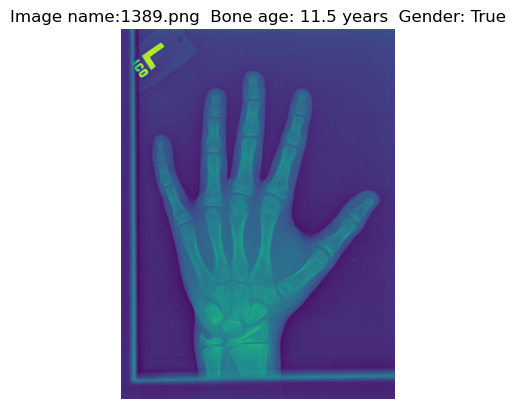

(2044, 1514)


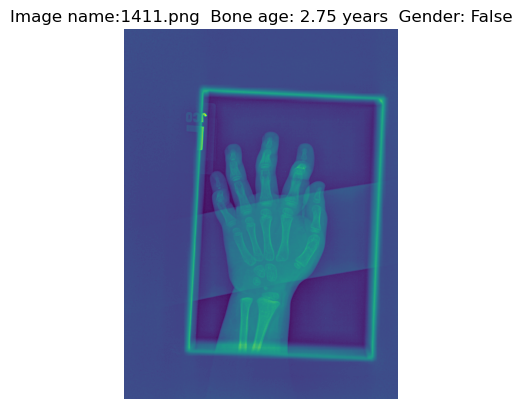

(2044, 1514)


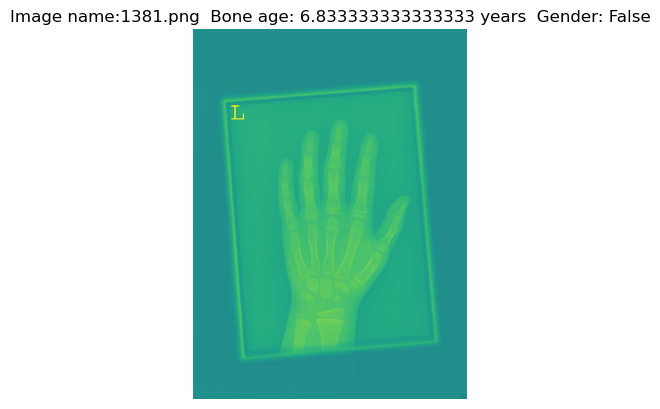

(2044, 1514)


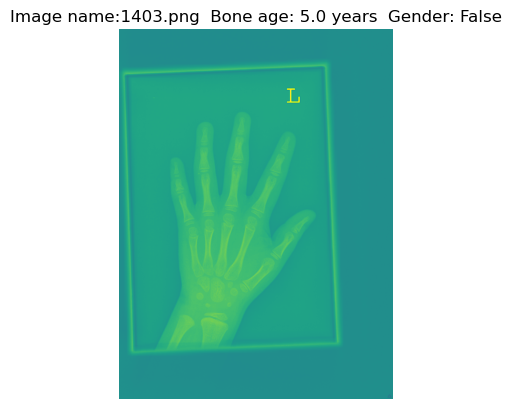

In [15]:
for filename, boneage, male in train_df[['id','boneage','male']].sample(4).values:

    # img = mpimg.imread(f"/home/teemo/Documents/bone_data/Bone Age Training Set/boneage-training-dataset/{filename}")
    img = mpimg.imread(f"/home/teemo/Documents/bone_data/Bone Age Small Set/boneage-small-dataset/{filename}")
    
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, male))
    print(img.shape)
    plt.axis('off')
    plt.show()

### Normalize the label/ target/ bone age prediction value/ y
target column: `bone_age_z`

In [16]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()
print(f"Standard Deviation {std_bone_age}")

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age) / (std_bone_age)

print(train_df.head())

MAX age: 188 months
MIN age: 4 months
mean: 106.75
median: 123.0
Standard Deviation 54.017320997453545
         id  boneage   male  bone_age_z
0  1377.png      180  False    1.356047
1  1378.png       12  False   -1.754067
2  1379.png       94  False   -0.236035
3  1380.png      120   True    0.245292
4  1381.png       82  False   -0.458186


In [17]:
# Test tensorflow resizing
resizer = tf.keras.layers.Resizing(256, 256)
X = tf.random.normal((1, 512, 512, 3), dtype=tf.dtypes.float32)
print(f"Go from shape (256, 256) -> {resizer(X).shape}")

Go from shape (256, 256) -> (1, 256, 256, 3)


In [18]:
resizer = tf.keras.layers.Resizing(256, 256)
img_size = 256
#train data generator
train_data_generator = ImageDataGenerator()

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    # directory = '/home/teemo/Documents/bone_data/Bone Age Training Set/boneage-training-dataset/',
    directory = '/home/teemo/Documents/bone_data/Bone Age Small Set/boneage-small-dataset/',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    # seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))


Found 32 validated image filenames.


In [19]:
# TODO figure out what does # ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) 
# do

# train_df = train_df.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# train_df = train_df.batch(32)
# train_df = train_df.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

### Model Parameters

In [ ]:
# 🐝 Step 2: Define sweep config
sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'mae_in_months'},
    'parameters': 
      {
        'layers': {'values': [64, 32, 16, 8]},
        'batch_size': {'values': [8, 16, 32]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.0001}
      }
}

# 🐝 Step 3: Initialize sweep by passing in config
sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-first-sweep')

In [ ]:
def train_with_sweep():
    # Weights and Biases run initialization
    run = wandb.init(project="test-project", entity="hda-project", name = "Base conv no gender info")
    config = wandb.config
    print(f"Wandb Config: {config}")

    # NETWORK MODEL
    model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None), 
                                tf.keras.layers.BatchNormalization(axis=-1),
                                tf.keras.layers.Activation('relu'),

                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

                                tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None),
                                tf.keras.layers.BatchNormalization(axis=-1),
                                tf.keras.layers.Activation('relu'),
                                
                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

                                tf.keras.layers.Flatten(),
                                # tf.keras.layers.Dense(32, activation='relu'),
                                tf.keras.layers.Dense(16, activation='relu'),
                                tf.keras.layers.Dense(1, activation = 'linear')
                                ])

    optimizer = tf.keras.optimizers.Adam( config["lr"] )

    #compile model
    model.compile(loss = 'mse', optimizer = optimizer , metrics = [mae_in_months] )

    # Train the model
    model.fit(train_generator, epochs = config["epochs"], callbacks=[WandbCallback()])

    # Save the Model
    # model.save('nn_models/base_conv_no_gender_info.h5')
    
    # model summary
    # model.build(input_shape=(None, 256, 256, 3))
    # model.summary()


In [ ]:

# Train the Model
# 🐝 Step 4: Call to `wandb.agent` to start a sweep
# wandb.agent(sweep_id, function=train_with_sweep, count=4)
wandb.agent(sweep_id, function=train_with_sweep )

# Tell W&B that a model run is complete
# run.update()
# run.join()

# Load the saved model
# model_loaded = tf.keras.models.load_model('signModel.h5')

In [17]:
test_X, test_Y = next(train_generator)
test_X.shape, test_Y

((32, 256, 256, 3),
 array([ 0.35636717,  1.50414716, -1.30976507, -1.42084055,  0.24529169,
        -0.86546314,  0.78215652,  0.24529169,  0.24529169,  0.57851814,
         0.46744266, -0.92100088, -1.30976507, -0.2360354 , -1.36530281,
         1.35604652, -0.53223669,  0.91174459, -0.01388444, -0.45818637,
        -1.90216764,  0.57851814,  0.8006691 ,  0.91174459,  0.57851814,
        -1.754067  ,  0.46744266,  1.35604652,  0.96728233,  0.35636717,
        -1.53191603,  0.91174459]))

In [18]:
# model.predict(test_X, batch_size = 32, verbose = True)

## Test the Model

1/1 [==============================] - 0s 113ms/step
20
11
8
6
1


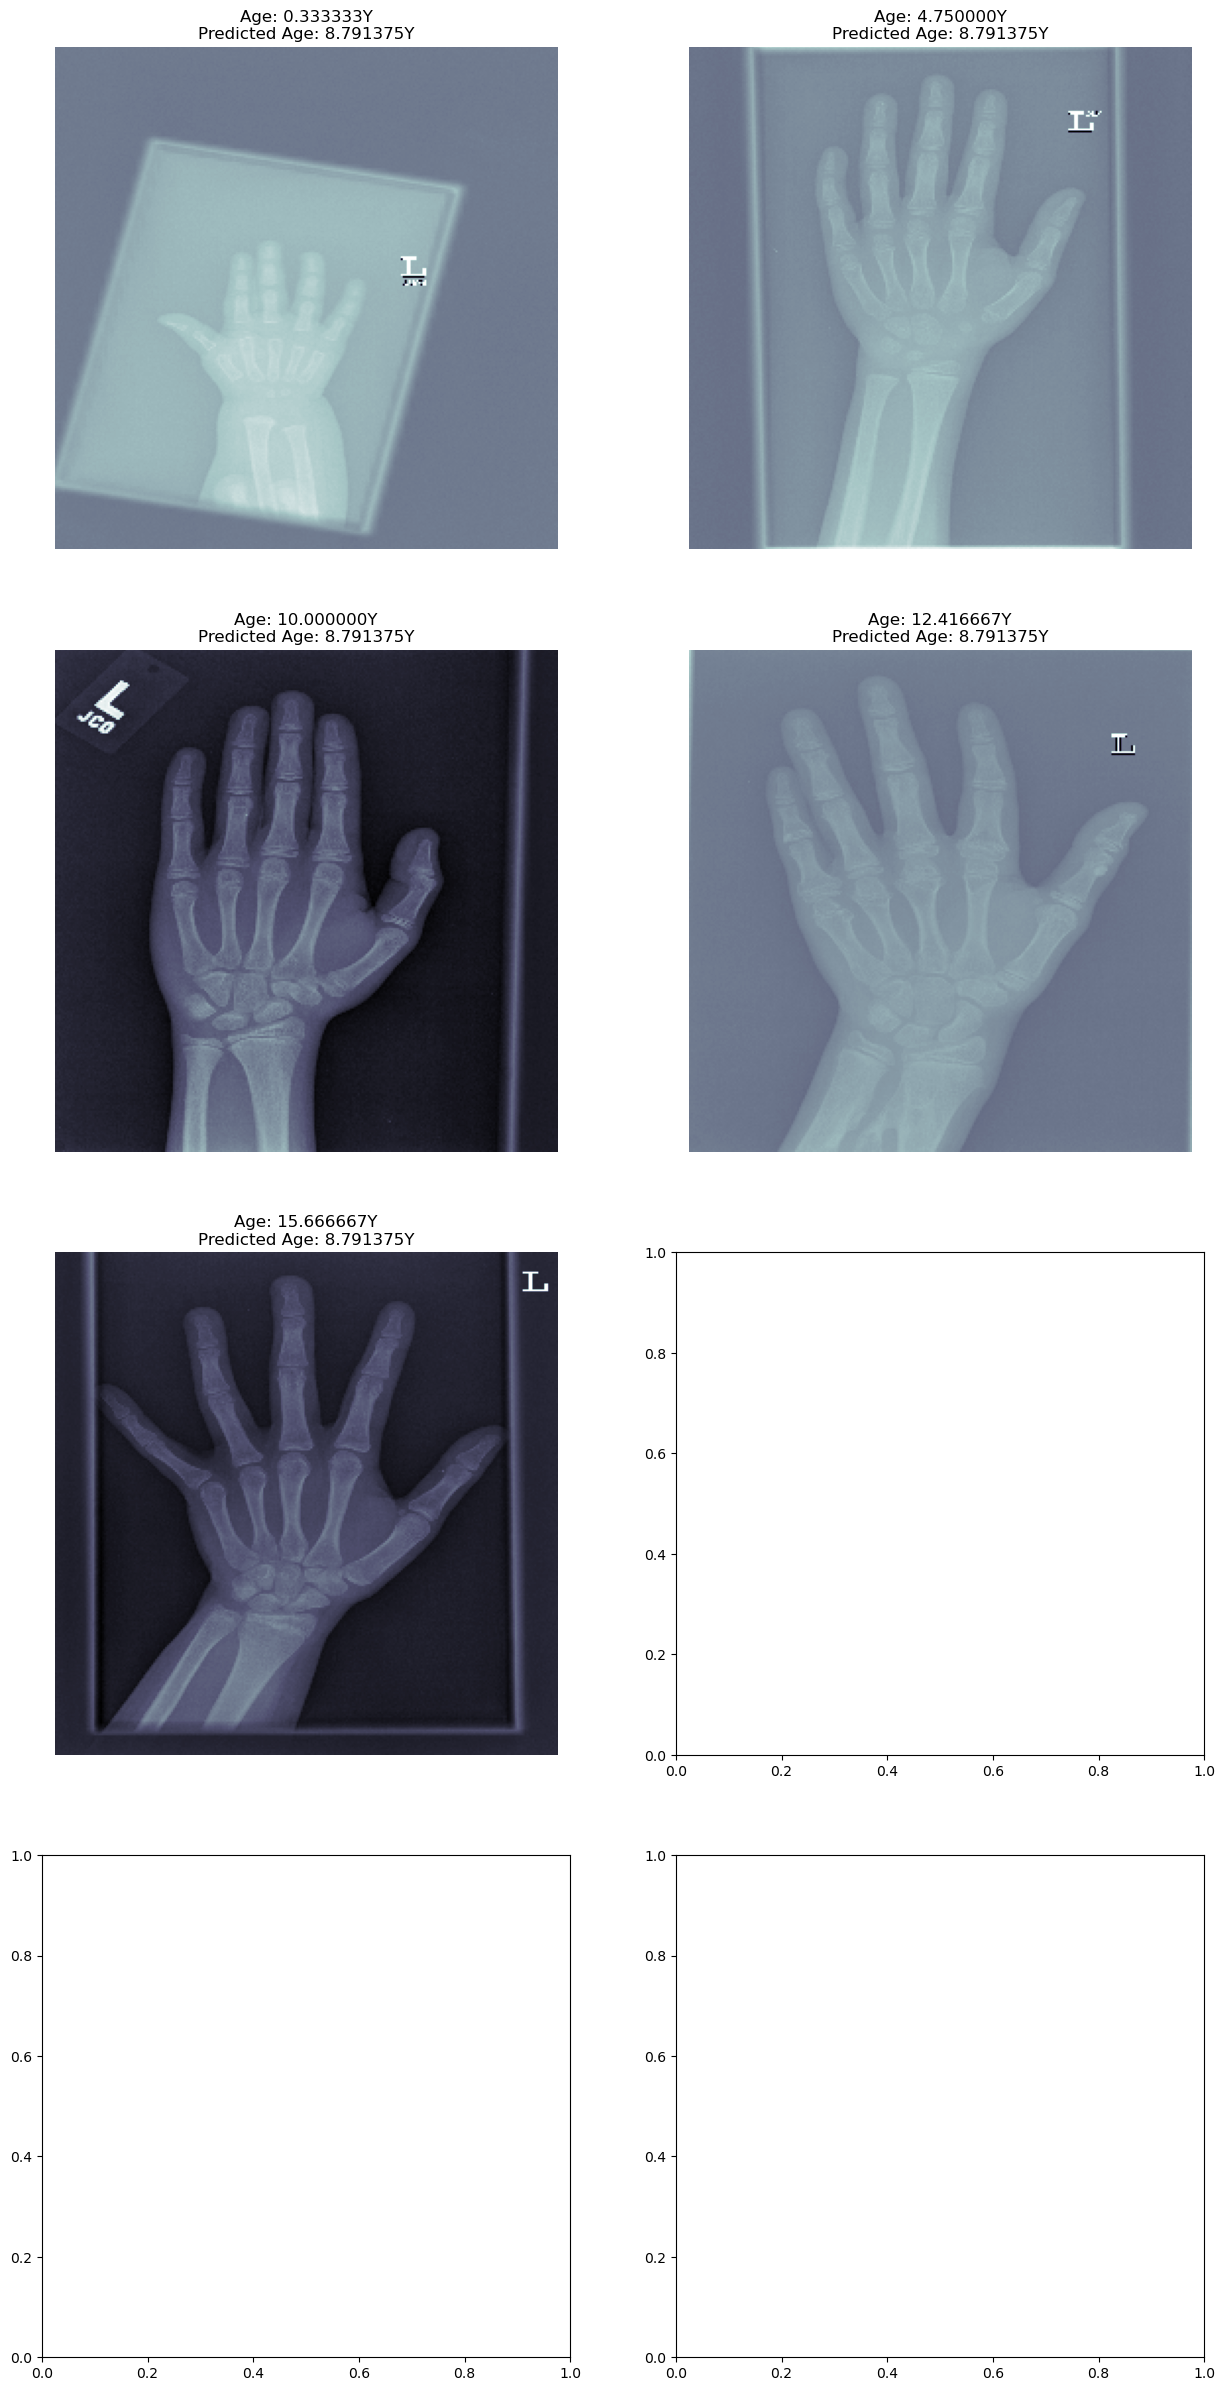

In [19]:
# model_2.load_weights('best_model.h5')
pred = mean_bone_age + std_bone_age*(model.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 5).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    print(ind)
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

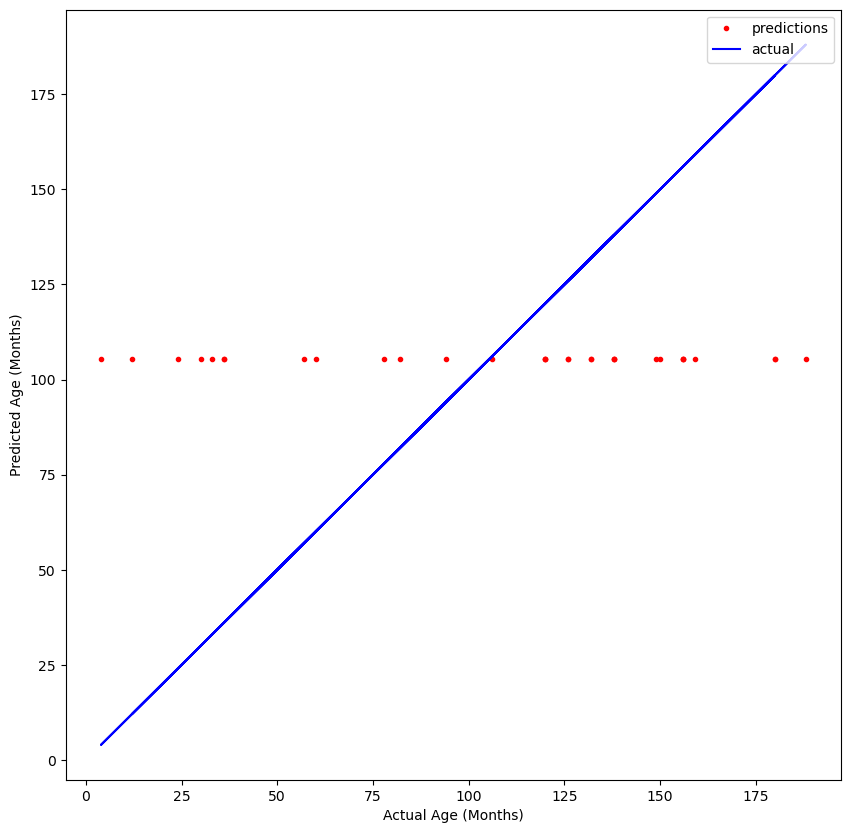

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')